# Compute the Optical Flow to determine the direction of the vehicles

Before running the code make sure to have all the videos uploaded in the google collab environment by uploading the videos.zip file from the github repository.


In [1]:
!unzip videos.zip

Archive:  videos.zip
replace videos/PXL_20210822_180954405.mp4? [y]es, [n]o, [A]ll, [N]one, [r]ename: None


### Auxiliary functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature
from skimage import filters
from scipy.stats import mode
import cv2
from google.colab.patches import cv2_imshow # because cv2.imshow crashes

# Function to display images
def display_image(img, title='', size=None):
    plt.gray()
    h = plt.imshow(img, interpolation='none')
    if size:
        dpi = h.figure.get_dpi()/size
        h.figure.set_figwidth(img.shape[1] / dpi)
        h.figure.set_figheight(img.shape[0] / dpi)
        h.figure.canvas.resize(img.shape[1] + 1, img.shape[0] + 1)
        h.axes.set_position([0, 0, 1, 1])
        h.axes.set_xlim(-1, img.shape[1])
        h.axes.set_ylim(img.shape[0], -1)
    plt.grid(False)
    plt.title(title)  
    plt.show()

# Function to preprocess images before using them
def preprocessing(frame):
    # Resize of frame while keeping ratio
    if frame.shape[1] > 800:
      scale_percent = 20 
      width = int(frame.shape[1] * scale_percent / 100)
      height = int(frame.shape[0] * scale_percent / 100)
      dim = (width, height)
    else: # if the width is already small don't make it smaller
      dim = (frame.shape[1], frame.shape[0])
    ## Function to resize image
    resized_frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
    
    # Convert to graylevel
    gray_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2GRAY)
    
    return gray_frame

## Static video


### Obtain background

In [3]:
def obtain_background(file_name):
  cap = cv2.VideoCapture(file_name)
  # read the video frame
  ret,frame = cap.read() 

  frame_gray = preprocessing(frame)

  # Define a 3D matrix to store the 100 images to generate the average
  width = frame_gray.shape[1]
  height = frame_gray.shape[0]
  all_frames = np.zeros((275,height,width))

  # Loop over frames from the video stream and accumulate all frames in a single variable                                                                                                    
  for i in range(275):
      if i%10 == 0:
        print ('Processing frame {}'.format (i))
      
      # Store the frame in the matrix
      all_frames[i,:,:] = frame_gray

      ret,frame = cap.read()
      if ret is False: # If something failed ...
          break
      frame_gray = preprocessing(frame)

  # Average the 100 frames
  background = np.average(all_frames,axis=0)

  # Convert to uint8 data type
  background = background.astype(np.uint8)

  return background

In [4]:
background = obtain_background('videos/PXL_20210822_180954405.mp4')

Processing frame 0
Processing frame 10
Processing frame 20
Processing frame 30
Processing frame 40
Processing frame 50
Processing frame 60
Processing frame 70
Processing frame 80
Processing frame 90
Processing frame 100
Processing frame 110
Processing frame 120
Processing frame 130
Processing frame 140
Processing frame 150
Processing frame 160
Processing frame 170
Processing frame 180
Processing frame 190
Processing frame 200
Processing frame 210
Processing frame 220
Processing frame 230
Processing frame 240
Processing frame 250
Processing frame 260
Processing frame 270


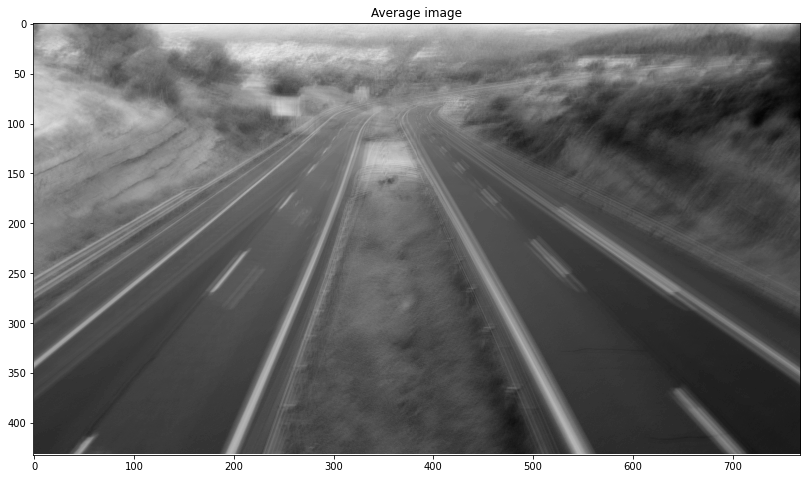

In [5]:
display_image(background, 'Average image', size=1)

The video has some movement, it will need to be stabilized to be able to obtain a clear background.

### Video stabilization

// TODO

### Already stabilized video 
#### Obtain background


Processing frame 0
Processing frame 10
Processing frame 20
Processing frame 30
Processing frame 40
Processing frame 50
Processing frame 60
Processing frame 70
Processing frame 80
Processing frame 90
Processing frame 100
Processing frame 110
Processing frame 120
Processing frame 130
Processing frame 140
Processing frame 150
Processing frame 160
Processing frame 170
Processing frame 180
Processing frame 190
Processing frame 200
Processing frame 210
Processing frame 220
Processing frame 230
Processing frame 240
Processing frame 250
Processing frame 260
Processing frame 270


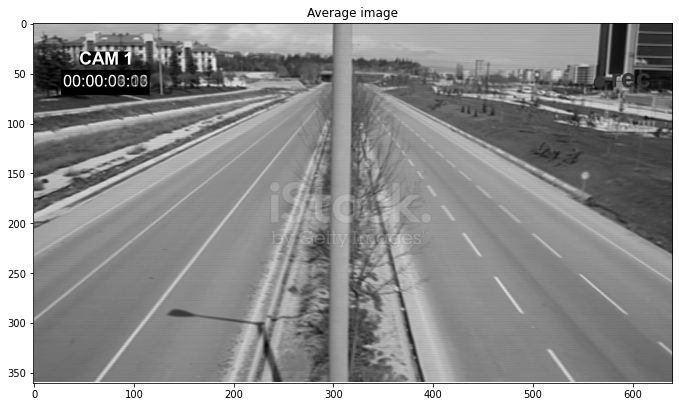

In [6]:
traffic_cam_background = obtain_background('videos/traffic_camera.mp4')
display_image(traffic_cam_background, 'Average image', size=1)

## Detecting moving objects

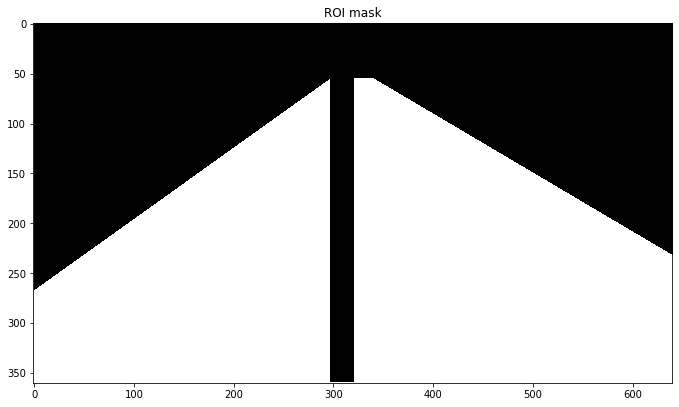

In [7]:
# Load the image defining the mask
roi_mask = cv2.imread('videos/traffic_camera_mask.png')
roi_mask = preprocessing(roi_mask*255)

display_image(roi_mask, 'ROI mask', size=1)

In [8]:
import time

cap = cv2.VideoCapture("videos/traffic_camera.mp4")

# read the video frame
success, frame = cap.read()

# Creating the kernels
kernel1 = np.ones((2,3), np.uint8)
kernel2 = np.ones((4,4), np.uint8)

# Config output video
## mp4
fourcc = cv2.VideoWriter_fourcc(*"MP4V")
writer = cv2.VideoWriter("movement_detection.mp4", fourcc, 30, (frame.shape[1], frame.shape[0]), False)
## avi
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
#writer = cv2.VideoWriter("movement_detection.avi", fourcc, 30, (frame.shape[1], frame.shape[0]), False)

while success:
    frame_gray = preprocessing(frame)
    
    moving_obj_frame = cv2.absdiff(traffic_cam_background, frame_gray)
    moving_obj_frame = cv2.bitwise_and(moving_obj_frame, roi_mask)
    th, moving_obj_frame = cv2.threshold(moving_obj_frame, 30, 255, cv2.THRESH_BINARY)
    img_erosion = cv2.erode(moving_obj_frame, kernel1, iterations=3)
    img_dilation = cv2.dilate(img_erosion, kernel2, iterations=4)
    
    # Display frame
    ## Google Collab display
    #cv2_imshow(frame_gray)
    #cv2_imshow(img_dilation)
    ## Jupyter notebook display
    #cv2_imshow('Movement detection', moving_obj_frame)
    #cv2_imshow('Erosion', img_erosion)
    #cv2_imshow('Dilation', img_dilation)
    #cv2_imshow('Traffic camera', frame_gray)
    #time.sleep(0.05)
    # creating 'q' as the quit button for the video
    #if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break

    # Write the output frame to disk
    writer.write(img_dilation)
    
    # Capture the next frame in the video
    success, frame = cap.read()

cv2.destroyAllWindows()
writer.release()

## Inside car video